alpha = 0.05, beta = 0.025, gamma = 0.05, period = 6


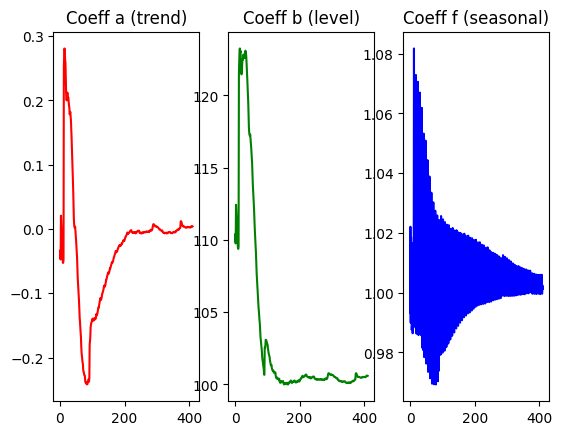

a[n-1] = 0.003937740550765833, b[n-1] = 100.5973433103832


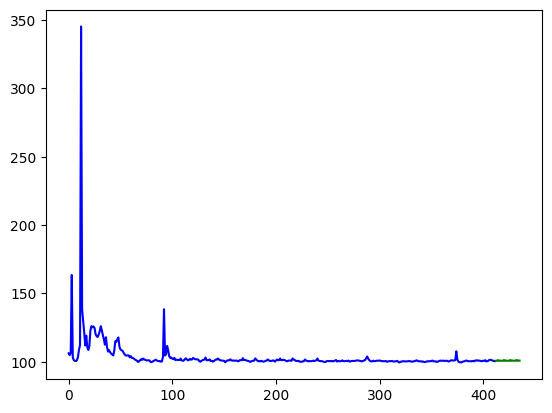

In [30]:
import pandas as pd
import numpy as np
import sklearn as skl
import sklearn.svm
from sklearn.metrics import mean_squared_error as mse
from matplotlib import pyplot as plt


class HoltWinters:
    def __init__(self, mult=False):
        super().__init__()
        self.a = None
        self.b = None
        self.f = None
        self.N = None
        self.L = None
        self.mult = mult


    def op(self, op1, op2, plus=False):
        return (op1 * op2 if self.mult else op1 + op2
                ) if plus else (op1 / op2 if self.mult else op1 - op2)


    def fit(self, data, L, alpha=0.5, beta=0.5, gamma=0.5, use_plot=False):
        regr_model = skl.linear_model.LinearRegression()
        t = np.arange(data.shape[0])
        regr_model.fit(t.reshape(-1, 1), data)
        y0 = regr_model.predict([[0]])[0]
        y1 = regr_model.predict([[1]])[0]
        a0 = (y1 - y0)
        b0 = y0
        a, b = [a0], [b0]
        self.N = data.shape[0]
        self.L = L
        k = data.shape[0] // L
        f_init = np.zeros(L)
        for i in range(0, k * L, L):
            f_init += self.op(data[i:i+L], (a0 * np.arange(i, i+L) + b0))
        f_init /= k
        f = np.zeros_like(data)
        f[range(1-L, 1)] = f_init
        for i in range(1, data.shape[0]):
            b_i = alpha * self.op(data[i], f[i - L]) + (1 - alpha) * (b[i - 1] +
                                                                      a[i - 1])
            b.append(b_i)
            a_i = beta * (b[i] - b[i - 1]) + (1 - beta) * a[i - 1]
            a.append(a_i)
            f_i = gamma * self.op(data[i], (b[i])) + (1 - gamma) * f[i - L]
            f[i] = f_i
        self.a = a
        self.b = b
        self.f = f
        if use_plot:
            fig, ax = plt.subplots(1, 3)
            ax[0].plot(t, a, 'r')
            ax[0].set_title('Coeff a (trend)')
            ax[1].plot(t, b, 'g')
            ax[1].set_title('Coeff b (level)')
            ax[2].plot(t, f, 'b')
            ax[2].set_title('Coeff f (seasonal)')
            plt.show()
        return a, b, f


    def predict(self, t_pred):
        x_pred = []
        for t_i in t_pred:
            idx = min(self.N, t_i - t_i % self.L) - 1
            t_diff = t_i - idx
            x_i = self.op(self.a[idx] * t_diff + self.b[idx],
                          self.f[idx + 1 + (t_diff - 1) % self.L - self.L],
                          plus=True)
            x_pred.append(x_i)
        return x_pred


    def get_score(self, data, t_step_score):
        N = data.shape[0]
        idx = max(0, N - t_step_score)
        data_pred = self.predict(np.arange(idx, N))
        return (mse(data_pred, data[idx:]))


    def tune(self, data, periods, count1=9, count2=3, delta=0.05, points=3,
             min_period=4, t_step_score=100):
        arr = np.arange(0, 1, count1)
        best_params = []
        best_score = np.inf
        scores = []
        t = np.arange(data.shape[0])
        per_count = count2
        N = data.shape[0]
        if not hasattr(periods, '__iter__'):
            periods = [periods]
            per_count = 1
        for alpha in arr:
            for beta in arr:
                for gamma in arr:
                    for L in periods:
                        a, b, f = self.fit(data, L, alpha, beta, gamma)
                        score = self.get_score(data, t_step_score)
                        scores.append((alpha, beta, gamma, score))
                        if score < best_score:
                            best_score = score
                            best_params_curr = [a, b, f, L, alpha, beta, gamma]
                            best_params.append(best_params_curr)
        best_params1 = best_params[-points:]
        best_params1.reverse()
        for _, _, _, L, alpha, beta, gamma in best_params1:
            for alpha1 in np.linspace(max(0, alpha - delta),
                                      min(1, alpha + delta), count2):
                for beta1 in np.linspace(max(0, beta - delta),
                                         min(1, beta + delta), count2):
                    for gamma1 in np.linspace(max(0, gamma - delta),
                                              min(1, gamma + delta), count2):

                        left = max(L - per_count // 2, min_period)
                        right = min(left + per_count, N)
                        a, b, f = self.fit(data, L, alpha1, beta1, gamma1)
                        score = self.get_score(data, t_step_score)
                        scores.append((alpha1, beta1, gamma1, score))
                        if score < best_score:
                            best_score = score
                            best_params_curr = [a, b, f, L, alpha1, beta1,
                                                gamma1]
                            best_params.append(best_params_curr)
        best_params = best_params[-1]
        self.a = best_params[0]
        self.b = best_params[1]
        self.f = best_params[2]
        self.L = best_params[3]
        self.alpha = best_params[4]
        self.beta = best_params[5]
        self.gamma = best_params[6]
        return best_params + [np.array(scores)]


def predict_data(X, horizont):
    hw_mult = HoltWinters(mult=True)
    periods = list(range(6, 40))
    res = hw_mult.tune(X, periods)
    a, b, f, L, alpha, beta, gamma, scores = res
    print(f'alpha = {alpha}, beta = {beta}, gamma = {gamma}, period = {L}')
    a1, b1, f1 = hw_mult.fit(X, L, alpha, beta, gamma, True)
    print(f'a[n-1] = {a1[-1]}, b[n-1] = {b1[-1]}')
    N = X.shape[0]
    t = np.arange(N)
    t_pred = np.arange(N, N + horizont)
    x_pred = hw_mult.predict(t_pred)
    plt.plot(t, X, 'b')
    plt.plot(t_pred, x_pred, 'g')


def get_data(file_csv, name):
    df = pd.read_csv(file_csv)
    return df[name]


def predict(file_csv, target, horizont):
    X = get_data(file_csv, target).to_numpy()
    X_pred = predict_data(X, horizont)
    return X_pred


if __name__ == "__main__":
    # file_name = '/content/cpi1991-2025.csv'
    # target = 'Значение'
    # horizont = 24
    file_name = input('Enter file path: ')
    target = input('Enter target name: ')
    horizont = int(input('Enter horizont length: '))
    predict(file_name, target, horizont)